In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

plt.style.use('ggplot')
seed = 101

Load data.

In [2]:
comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [3]:
annotations = pd.read_csv('../data/toxicity_annotations.tsv', sep='\t')
annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


Let's start by fixing some escaped characters: newline, tab, and quote (").

In [4]:
def fix_characters(text):
    text = re.sub(r'NEWLINE_TOKEN', '\n', text)
    text = re.sub(r'TAB_TOKEN', '\t', text)
    text = re.sub(r'`', '"', text)
    return text

comments['comment'] = comments['comment'].map(fix_characters)
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


Now that we have "clean" dataset, let's look at the distribution of comments and see if we see anything interesting.

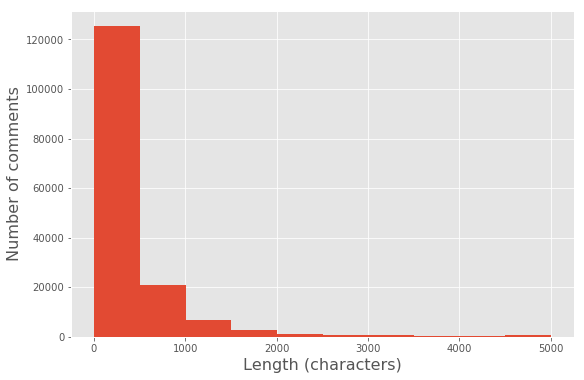

In [5]:
lengths = comments['comment'].map(len)

plt.figure(figsize=(9,6))
plt.hist(lengths)
plt.xlabel('Length (characters)', fontsize=16)
plt.ylabel('Number of comments', fontsize=16)
plt.show()

Do we have any duplicate comments?

In [6]:
unique_comments = comments.groupby('comment')['rev_id'].count().reset_index()
unique_comments[unique_comments['rev_id'] > 1].sort_values('rev_id', ascending=False).head()

,comment,rev_id
127769,"""\n==The Graceful Slick....==\nIs non other th...",8
136913,"""Thank you for experimenting with Wikipedia. ...",7
128433,"""\nWelcome\n\nHello and welcome to Wikipedia! ...",6
136915,"""Thank you for experimenting with Wikipedia. ...",6
152360,Thank you for experimenting with Wikipedia. Y...,5


Looks like there are some boilerplate messages. We may want to drop duplicates, but let's look at getting labels before we consider that. Each comment has multiple annotations, where the annotator has assigned a score. The score is based on a survey shown in the docs folder. The questions are as follows:

- Very toxic (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion)
- Toxic (a rude, disrespectiful, or unreasonable comment that is somehwat likely to make you leave a discussion)
- Neither
- Healthy contribution (a reasonable, civil, or polite contribution that is somewhat likely to make you want to continue a discussion)
- Very healthly contribution (a very polite, throughful, or helpful contribution that is very likely to make you want to continue a discussion)

From top to bottom, the scores are -2, -1, 0, 1, and 2. We need to find a way to aggregate the toxicity_scores assigned to each comment. Also, what is the distribution of annotations over rev_id?

In [7]:
annotations.groupby('rev_id')['toxicity_score'].count().describe()

count    159686.000000
mean         10.008949
std           0.450793
min           8.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          21.000000
Name: toxicity_score, dtype: float64

In [8]:
def agg_toxicity_scores(sub):
    result = {}
    result['min'] = sub['toxicity_score'].min()
    result['max'] = sub['toxicity_score'].max()
    result['avg'] = sub['toxicity_score'].mean()
    return pd.Series(result)

scores = annotations.groupby('rev_id').apply(agg_toxicity_scores).reset_index()
scores.head()

,rev_id,min,max,avg
0,2232.0,-1.0,1.0,0.4
1,4216.0,0.0,2.0,0.5
2,8953.0,0.0,1.0,0.1
3,26547.0,0.0,2.0,0.6
4,28959.0,-1.0,1.0,0.2


Now we can merge back into the comments dataframe.

In [9]:
df = pd.merge(comments, scores, on='rev_id')
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,min,max,avg
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,-1.0,1.0,0.4
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,0.0,2.0,0.5
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0.0,1.0,0.1
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,0.0,2.0,0.6
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,-1.0,1.0,0.2


Before we go much further, let's take a look at some of the "toxic" comments. In theory, those with a max toxicity score of -2.0 should be the worst. Is that true?

In [10]:
idx = df['max'] == -2.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

40815    YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...
90280    FUCKING BITCHES THAT ARE READING THIS. JASENM2...
90685    NJGW IS AN UNEMPLOYED MOTHER FUCKING BASTARD L...
59017    \n\n== jerk me jolly ==\n\nfuckfuckfuckfuckfuc...
29133    \n\nFUCKING COCKSUCKING ADMINS, EAT MY SHIT CU...
98873    \n\n\n==You Cunt ==\nGo fuck yourself you piec...
51127    \n\n\nFUCK OFFFUCK OFFFUCK OFFFUCK OFFFUCK OFF...
76810    \n\n==Fuck You==\n\nGo suck on a fat dick fagg...
81942    SUCK MY COCK D SUCK MY COCK D SUCK MY COCK D S...
79522    YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A...
Name: comment, dtype: object

Yup. All terrible. What about the other end? In theory, those with a min toxicity score of 2.0 should be the best. Is that true?

In [11]:
idx = df['min'] == 2.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

ValueError: 'a' must be greater than 0 unless no samples are taken

Ironically, _nobody_ has a min toxicity score equal to 2.0. I guess the bar is just higher for good content. Let's look at the distribution of the mean toxicity score and try to find a few with high marks.

In [12]:
df['avg'].quantile([0.9, 0.95, 0.99])

0.90    0.7
0.95    0.8
0.99    1.0
Name: avg, dtype: float64

In [13]:
idx = df['avg'] >= 1.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

68722     "\n::We might want to consider redirecting it ...
143203    "\n:sorry for reverting you! I did not mean to...
152634    "\n\n== Please correct two of the contribution...
136008    \n\n* DDD. Thank you  for your time and effort...
81762                 Thanks for fixing the problem.   \n\n
155267    \n\n==Hi==\nHey Ebyabe... Look listen... I'm s...
26909     \ni am sorry for any trouble i have caused. My...
89714     \n:Civility please. That link is the place whe...
113806    \n::::That's good by me then, Gabriel. Thanks ...
8590      Welcome!\n\nHello , and welcome to Wikipedia! ...
Name: comment, dtype: object

Interesting. At least a few of these comments are an appeal for civility. Now that we have a better understanding of what constitutes the two classes, we need to make a decision about our target. A safe bet is to group everything with a mean score equal to or above 0.0 as a non-toxic message.

In [14]:
df['y'] = df['avg'].map(lambda x: int(x < 0))
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,min,max,avg,y
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,-1.0,1.0,0.4,0
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,0.0,2.0,0.5,0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0.0,1.0,0.1,0
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,0.0,2.0,0.6,0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,-1.0,1.0,0.2,0


In [15]:
df['y'].value_counts(normalize=True)

0    0.815532
1    0.184468
Name: y, dtype: float64

Roughly 18.5% of all comments are toxic. Now that we have labels, let's revisit the comments. First, we need to break up the text into tokens. Let's start by grabbing all alpha tokens. How many unique tokens are in the comments?

In [16]:
def tokenize(text):
    return re.findall(r'[a-zA-Z]+', text)

idx_train = df['split'] == 'train'
idx_dev = df['split'] == 'dev'
idx_test = df['split'] == 'test'

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:02<00:00, 38245.75it/s]


157978

That is a _lot_ of features. What happens if we allow alphanumeric tokens?

In [17]:
def tokenize(text):
    return re.findall(r'[a-zA-Z0-9]+', text)

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:02<00:00, 36747.83it/s]


166277

It actually doesn't blow things up too much. What do those alphanumeric tokens look like?

In [18]:
numeric_tokens = []
for token in tqdm(token_dict.keys()):
    if np.any([c.isnumeric() for c in token]):
        numeric_tokens.append(token)

100%|██████████████████████████████████████████████████████████████████████| 166277/166277 [00:00<00:00, 218777.57it/s]


In [19]:
numeric_tokens[:20]

['n8chz',
 '1603',
 '1543',
 '13',
 '34',
 '26',
 '2002',
 '1861',
 '3',
 '16',
 '17',
 '15',
 '9',
 '1887',
 '19',
 '02',
 '25',
 '10',
 '18',
 '40']

It's not clear that we would need these tokens, and the truth is that numeric tokens can quickly blow up your feature space. Let's exclude them and try to reduce the overall number of tokens by casting everything to lowercase.

In [20]:
def tokenize(text):
    return re.findall(r'[a-z0-9]+', text.lower())

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:02<00:00, 36236.79it/s]


132883

A little lower, which is encouraging. Everything we've done up to now can be done in scikit-learn and gensim, but I wanted to look at python primatives to get a better feel for what is going on behind the scenes. Let's look at token document frequency by modifying out dictionary code from above.

In [21]:
def tokenize(text):
    return re.findall(r'[a-z0-9]+', text.lower())

df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:02<00:00, 36041.89it/s]


132883

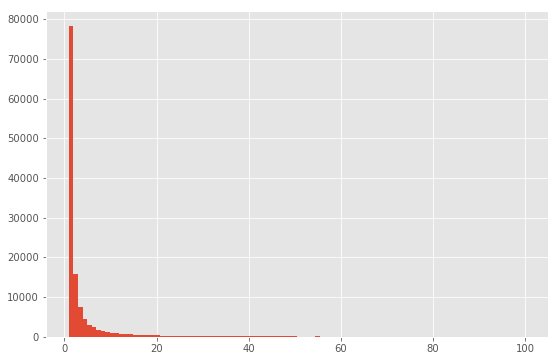

In [22]:
dfs = list(df_token_dict.values())

plt.figure(figsize=(9,6))
plt.hist(dfs, bins=100, range=(1,100))
plt.show()

In [23]:
pd.value_counts(dfs, normalize=True)

1        0.589075
2        0.119910
3        0.056034
4        0.034421
5        0.023216
6        0.017707
7        0.013373
8        0.010776
9        0.008760
10       0.007668
11       0.006532
12       0.005426
13       0.004771
14       0.004372
15       0.004034
16       0.003499
18       0.003093
17       0.003025
19       0.002867
20       0.002521
21       0.002288
22       0.002130
23       0.001987
24       0.001904
25       0.001881
26       0.001806
29       0.001528
27       0.001520
28       0.001422
30       0.001204
           ...   
686      0.000008
558      0.000008
2394     0.000008
475      0.000008
603      0.000008
859      0.000008
2139     0.000008
1497     0.000008
2481     0.000008
1241     0.000008
12724    0.000008
2483     0.000008
984      0.000008
1112     0.000008
1496     0.000008
1329     0.000008
1073     0.000008
945      0.000008
2992     0.000008
3545     0.000008
1624     0.000008
4403     0.000008
985      0.000008
2096     0.000008
7987     0

Threshold is obviously going to have a large effect on the total vocabulary. Finally, let's look at the distribution of token sizes.

In [24]:
tokens = np.array(list(df_token_dict.keys()))
token_len = np.array([len(token) for token in tokens])
token_len

array([ 2,  3,  4, ..., 15, 10,  9])

In [25]:
(token_len > 24).sum()

249

In [26]:
tokens[token_len > 24]

array(['downingstreetmemogetsfreshattention',
       'hooooooooooooooooooooooooooo', 'zlqdxksg9p011ixmjmvloswglf',
       'v880tkl4iqqei81y7bnl3nrqicgjiqcju6zmhncy',
       'v880tkl4iqgywfkof69nrg2mtu', 'childrennononoooo88tobies',
       'pondinfrontofschiavograve',
       'timedarticlechangestabilisationmechanism',
       'aolanaonwaswronglyaccused',
       '11111111111111111111111111oneoneoneoneoneoneoneoneoneoneoenone',
       'pleeeeeeeeeeeeeaaaaaaaaaaaaaaaaaaaaaassssssssssssssssseeeeeeeeeeeee',
       '1searchenginemarketingcompany', 'computerfacialanimation3dmesh',
       'computerfacialanimationfdp', 'computerfacialanimationmorph',
       'computerfacialanimationparke', 'doooooooooooooooooooooooomed',
       'hahahahahahahahahahhahahahhhahhahahahahahhahahahahahahahahahahahahahahahahahahahhaahhahahahahaahaahhahaahhahahaha',
       'brrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr',
       'touchmyshitagainandyoulllearnwahtitmeanstotossasaladfatnerdfuckingtrollpieceofshitasswipe

I'm guessing these tokens don't contribute much to discussions. We should keep these in mind as we move into model creation. Before we go, let's dump the dataframe into a sqlite database so we don't have to reprocess everything.

In [27]:
import sqlite3 as sql

with sql.connect('../data/toxic.db') as conn:
    df.to_sql('toxic', conn, index=False)